In [11]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

import pingouin as pg


In [2]:
base_dir = '/Users/hugofluhr/phd_local/data/LearningHabits/dev_sample'
sub_ids = load_participant_list(base_dir)

In [3]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=False) for sub_id in sub_ids]

/Users/hugofluhr/phd_local/repositories/learning-habits-analysis/notebooks/../utils/data.py:178: UserWarning: Last 1 trial(s) of block had no response, filling with 0


# Code using repeated measure correlation
code to look at the effect of excluding trials with highest/lowest stim on the correlation
between Q and H values.

In [32]:
df = pd.concat(
    [
        pd.concat(
            [
                pd.DataFrame({'sub_id': [sub.sub_id] * len(sub.extended_trials)}),
                sub.extended_trials.reset_index(drop=True)
            ],
            axis=1
        )
        for sub in subjects
    ],
    ignore_index=True
)

In [33]:
df.head()

,sub_id,block,left_stim,right_stim,left_value,right_value,shift,action,rt,chosen_stim,...,stim1_prop_training,stim2_prop_training,stim_diff_prop_training,stim_diff_prop_training_chosen,reward1C,stim_diff_prop_trainingS,stim_diff_prop_training_chosenS,diff_valS,diff_val_chosenS,score_EHI
0,sub-01,learning1,5,7,3,4,0,1.0,0.934432,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-01,learning1,4,6,3,4,1,1.0,0.645392,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-01,learning1,3,1,2,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-01,learning1,6,8,4,5,0,1.0,0.368762,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-01,learning1,2,4,2,3,0,1.0,0.537730,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# how many non-response trials
nan_counts = df.groupby('sub_id')['action'].apply(lambda x: x.isna().sum())
mean_nan = nan_counts.mean()
std_nan = nan_counts.std()
print(f"Mean number of non-response (NaN) trials per subject: {mean_nan:.2f} ± {std_nan:.2f}")

Mean number of non-response (NaN) trials per subject: 5.21 ± 4.03


## Split Learning and Test

In [34]:
df_learning = df[df['block'].str.startswith('learning')].reset_index(drop=True)
df_test = df[df['block'] == 'test'].reset_index(drop=True)

## Create masks for exclusion analysis

In [35]:
# Learning data masks
mask_first_stim_learning = ((df_learning['first_stim'] == 1) | (df_learning['first_stim'] == 8))
mask_second_stim_learning = ((df_learning['second_stim'] == 1) | (df_learning['second_stim'] == 8))
mask_combined_learning = mask_first_stim_learning | mask_second_stim_learning

# Test data masks  
mask_first_stim_test = ((df_test['first_stim'] == 1) | (df_test['first_stim'] == 8))
mask_second_stim_test = ((df_test['second_stim'] == 1) | (df_test['second_stim'] == 8))
mask_combined_test = mask_first_stim_test | mask_second_stim_test

# Calculate trial counts and exclusion statistics
total_trials_learning = len(df_learning)
total_trials_test = len(df_test)
excluded_first_stim_learning = mask_first_stim_learning.sum()
excluded_first_stim_test = mask_first_stim_test.sum()
excluded_combined_learning = mask_combined_learning.sum()
excluded_combined_test = mask_combined_test.sum()

print("=== LEARNING DATA ===")
print(f"Total number of learning trials: {total_trials_learning:,}")
print(f"Trials excluded by mask_first_stim: {excluded_first_stim_learning:,} ({excluded_first_stim_learning/total_trials_learning:.2%})")
print(f"Trials excluded by mask_combined: {excluded_combined_learning:,} ({excluded_combined_learning/total_trials_learning:.2%})")

print("\n=== TEST DATA ===")
print(f"Total number of test trials: {total_trials_test:,}")
print(f"Trials excluded by mask_first_stim: {excluded_first_stim_test:,} ({excluded_first_stim_test/total_trials_test:.2%})")
print(f"Trials excluded by mask_combined: {excluded_combined_test:,} ({excluded_combined_test/total_trials_test:.2%})")

=== LEARNING DATA ===
Total number of learning trials: 11,904
Trials excluded by mask_first_stim: 2,943 (24.72%)
Trials excluded by mask_combined: 5,952 (50.00%)

=== TEST DATA ===
Total number of test trials: 8,432
Trials excluded by mask_first_stim: 1,753 (20.79%)
Trials excluded by mask_combined: 3,224 (38.24%)


## RM corr with all trials

In [36]:
first_stim_corr = pg.rm_corr(data=df_learning, 
                             y='first_stim_value_ck',
                             x='first_stim_value_rl', 
                             subject='sub_id')
print(first_stim_corr)
second_stim_corr = pg.rm_corr(data=df_learning, 
                              x='second_stim_value_rl', 
                              y='second_stim_value_ck',
                              subject='sub_id')
print(second_stim_corr)
pg.corr(x= df_learning.first_stim_value_rl, 
        y= df_learning.first_stim_value_ck)

                r    dof  pval         CI95%  power
rm_corr  0.349277  11841   0.0  [0.33, 0.36]    1.0
                r    dof  pval         CI95%  power
rm_corr  0.358029  11841   0.0  [0.34, 0.37]    1.0


,n,r,CI95%,p-val,BF10,power
pearson,11904,0.29836,"[0.28, 0.31]",2.685773e-243,9.543e+238,1.0


In [37]:
first_stim_corr = pg.rm_corr(data=df_test, 
                             y='first_stim_value_ck',
                             x='first_stim_value_rl', 
                             subject='sub_id')
print(first_stim_corr)
second_stim_corr = pg.rm_corr(data=df_test, 
                              x='second_stim_value_rl', 
                              y='second_stim_value_ck',
                              subject='sub_id')
print(second_stim_corr)
pg.corr(x= df_test.first_stim_value_rl, 
        y= df_test.first_stim_value_ck)

                r   dof  pval        CI95%  power
rm_corr  0.611678  8369   0.0  [0.6, 0.62]    1.0
                r   dof  pval         CI95%  power
rm_corr  0.603386  8369   0.0  [0.59, 0.62]    1.0


,n,r,CI95%,p-val,BF10,power
pearson,8432,0.475094,"[0.46, 0.49]",0.0,inf,1.0


## RM corr excluding all trials with highest/lowest

### First stim exclusion only

#### Learning data

In [38]:
# Use pre-calculated masks for learning data
df_first_stim_learning = df_learning[~mask_first_stim_learning]

print(f"Learning - Trials excluded by mask_first_stim: {excluded_first_stim_learning:,} ({excluded_first_stim_learning/total_trials_learning:.2%})")
print(f"Learning - Remaining trials after exclusion: {len(df_first_stim_learning):,} ({len(df_first_stim_learning)/total_trials_learning:.2%})")

first_stim_corr_f1_learning = pg.rm_corr(data=df_first_stim_learning, 
                             y='first_stim_value_ck',
                             x='first_stim_value_rl', 
                             subject='sub_id')
print(first_stim_corr_f1_learning)

second_stim_corr_f1_learning = pg.rm_corr(data=df_first_stim_learning, 
                              x='second_stim_value_rl', 
                              y='second_stim_value_ck',
                              subject='sub_id')
print(second_stim_corr_f1_learning)

Learning - Trials excluded by mask_first_stim: 2,943 (24.72%)
Learning - Remaining trials after exclusion: 8,961 (75.28%)
                r   dof      pval         CI95%     power
rm_corr  0.038257  8898  0.000306  [0.02, 0.06]  0.950582
                r   dof  pval        CI95%  power
rm_corr  0.483405  8898   0.0  [0.47, 0.5]    1.0


#### Test data

In [39]:
# Use pre-calculated masks for test data
df_first_stim_test = df_test[~mask_first_stim_test]

print(f"Test - Trials excluded by mask_first_stim: {excluded_first_stim_test:,} ({excluded_first_stim_test/total_trials_test:.2%})")
print(f"Test - Remaining trials after exclusion: {len(df_first_stim_test):,} ({len(df_first_stim_test)/total_trials_test:.2%})")

first_stim_corr_f1_test = pg.rm_corr(data=df_first_stim_test, 
                             y='first_stim_value_ck',
                             x='first_stim_value_rl', 
                             subject='sub_id')
print(first_stim_corr_f1_test)

second_stim_corr_f1_test = pg.rm_corr(data=df_first_stim_test, 
                              x='second_stim_value_rl', 
                              y='second_stim_value_ck',
                              subject='sub_id')
print(second_stim_corr_f1_test)

Test - Trials excluded by mask_first_stim: 1,753 (20.79%)
Test - Remaining trials after exclusion: 6,679 (79.21%)
                r   dof          pval         CI95%  power
rm_corr  0.207909  6616  1.546938e-65  [0.18, 0.23]    1.0
                r   dof  pval        CI95%  power
rm_corr  0.619318  6616   0.0  [0.6, 0.63]    1.0


### First and second stim exclusion

#### Learning data

In [40]:
# Use pre-calculated masks for learning data
df_both_learning = df_learning[~mask_combined_learning]

print(f"Learning - Trials excluded by mask_combined: {excluded_combined_learning:,} ({excluded_combined_learning/total_trials_learning:.2%})")
print(f"Learning - Remaining trials after exclusion: {len(df_both_learning):,} ({len(df_both_learning)/total_trials_learning:.2%})")

first_stim_corr_f2_learning = pg.rm_corr(data=df_both_learning, 
                             y='first_stim_value_ck',
                             x='first_stim_value_rl', 
                             subject='sub_id')
print(first_stim_corr_f2_learning)

second_stim_corr_f2_learning = pg.rm_corr(data=df_both_learning, 
                              x='second_stim_value_rl', 
                              y='second_stim_value_ck',
                              subject='sub_id')
print(second_stim_corr_f2_learning)

Learning - Trials excluded by mask_combined: 5,952 (50.00%)
Learning - Remaining trials after exclusion: 5,952 (50.00%)
                r   dof          pval         CI95%  power
rm_corr  0.199506  5889  5.969354e-54  [0.17, 0.22]    1.0
                r   dof          pval         CI95%  power
rm_corr  0.204197  5889  1.742023e-56  [0.18, 0.23]    1.0


#### Test data

In [41]:
# Use pre-calculated masks for test data
df_both_test = df_test[~mask_combined_test]

print(f"Test - Trials excluded by mask_combined: {excluded_combined_test:,} ({excluded_combined_test/total_trials_test:.2%})")
print(f"Test - Remaining trials after exclusion: {len(df_both_test):,} ({len(df_both_test)/total_trials_test:.2%})")

first_stim_corr_f2_test = pg.rm_corr(data=df_both_test, 
                             y='first_stim_value_ck',
                             x='first_stim_value_rl', 
                             subject='sub_id')
print(first_stim_corr_f2_test)

second_stim_corr_f2_test = pg.rm_corr(data=df_both_test, 
                              x='second_stim_value_rl', 
                              y='second_stim_value_ck',
                              subject='sub_id')
print(second_stim_corr_f2_test)

Test - Trials excluded by mask_combined: 3,224 (38.24%)
Test - Remaining trials after exclusion: 5,208 (61.76%)
                r   dof          pval         CI95%  power
rm_corr  0.205495  5145  3.375512e-50  [0.18, 0.23]    1.0
                r   dof          pval         CI95%  power
rm_corr  0.208758  5145  8.775824e-52  [0.18, 0.23]    1.0


# Old stuff
code up until August 2025

In [72]:
df = subjects[0].extended_trials

In [73]:
rl_cols = [col for col in df.columns if col.startswith('stim') and col.endswith('_value_rl')]
ck_cols = [col for col in df.columns if col.startswith('stim') and col.endswith('_value_ck')]

In [74]:
RL_values = np.zeros((len(subjects), len(df), len(rl_cols)))
CK_values = np.zeros((len(subjects), len(df), len(ck_cols)))

In [75]:
for i, sub in enumerate(subjects):
    RL_values[i] = sub.extended_trials[rl_cols].values
    CK_values[i] = sub.extended_trials[ck_cols].values

In [76]:
from itertools import cycle
def plot_mean_sem_stimuli(data, axis=None, colors=None, labels=None, alpha=0.3):
    """
    Plots mean ± SEM timecourses for each stimulus.

    Parameters:
    - data: 3D array of shape (n_subjects, n_timepoints, n_stimuli)
    - axis: matplotlib axis (optional)
    - colors: list of colors for each stimulus (optional)
    - labels: list of labels for each stimulus (optional)
    - alpha: transparency for shaded area
    """
    if axis is None:
        axis = plt.gca()

    n_subjects, n_timepoints, n_stimuli = data.shape
    timepoints = np.arange(n_timepoints)

    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for i in range(n_stimuli):
        stim_data = data[:, :, i]
        mean = np.mean(stim_data, axis=0)
        sem = np.std(stim_data, axis=0, ddof=1) / np.sqrt(n_subjects)

        color = next(color_cycle)
        label = labels[i] if labels else f'Stimulus {i+1}'

        axis.plot(timepoints, mean, color=color, label=label)
        axis.fill_between(timepoints, mean - sem, mean + sem, color=color, alpha=alpha)

    axis.set_xlabel('Time (TRs)')
    axis.set_ylabel('Signal (a.u.)')
    return axis

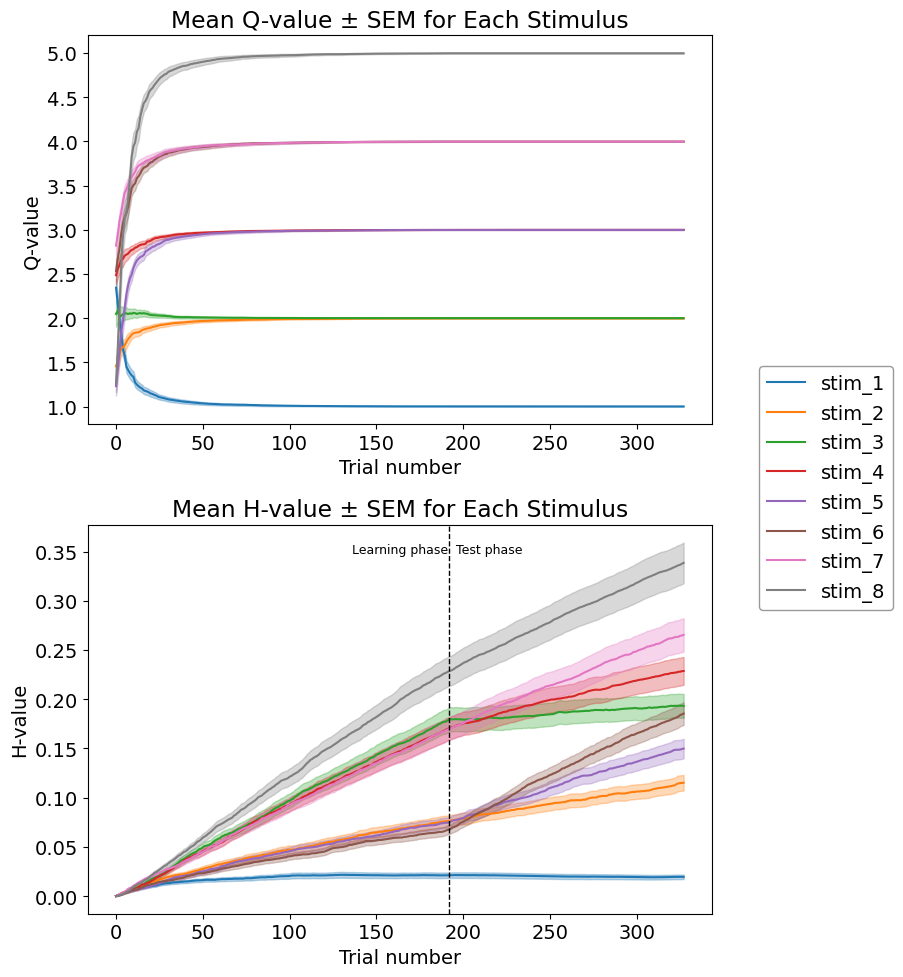

In [77]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Q-values subplot
plot_mean_sem_stimuli(
    RL_values,
    axis=axs[0],
    labels=['stim_' + str(i) for i in range(1, RL_values.shape[2] + 1)]
)
axs[0].set_xlabel('Trial number')
axs[0].set_ylabel('Q-value')
axs[0].set_title('Mean Q-value ± SEM for Each Stimulus')

# H-values subplot
plot_mean_sem_stimuli(
    CK_values,
    axis=axs[1],
    labels=['stim_' + str(i) for i in range(1, CK_values.shape[2] + 1)]
)
axs[1].set_xlabel('Trial number')
axs[1].set_ylabel('H-value')
axs[1].set_title('Mean H-value ± SEM for Each Stimulus')

# Add vertical line at trial 196
axs[1].axvline(x=192, color='black', linestyle='--', linewidth=1)
axs[1].text(136, axs[1].get_ylim()[1] * 0.95, 'Learning phase', fontsize=9, verticalalignment='top')
axs[1].text(196, axs[1].get_ylim()[1] * 0.95, 'Test phase', fontsize=9, verticalalignment='top')

# Create shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='center left',
    bbox_to_anchor=(0.95, 0.5),
    frameon=True
).get_frame().set_edgecolor('gray')

plt.tight_layout(rect=[0, 0, 0.93, 1])  # leave space for legend
plt.show()

In [78]:
C = np.zeros((RL_values.shape[0],))
for s in range(RL_values.shape[0]):
    C[s] = np.corrcoef(RL_values[s,...].flatten(), CK_values[s,...].flatten())[0,1]

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


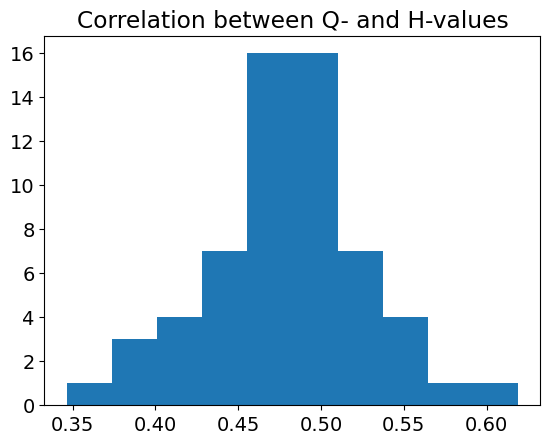

In [79]:
plt.hist(C, density=False)
plt.title('Correlation between Q- and H-values')
plt.show()

# Excluding highest/lowest stimuli

In [80]:
# excluding lowest and highest value stimuli:
rl_cols = rl_cols[1:-1]
ck_cols = ck_cols[1:-1]

In [81]:
RL_values = np.zeros((len(subjects), len(df), len(rl_cols)))
CK_values = np.zeros((len(subjects), len(df), len(ck_cols)))

In [82]:
for i, sub in enumerate(subjects):
    RL_values[i] = sub.extended_trials[rl_cols].values
    CK_values[i] = sub.extended_trials[ck_cols].values

Text(0.5, 1.0, 'H-values')

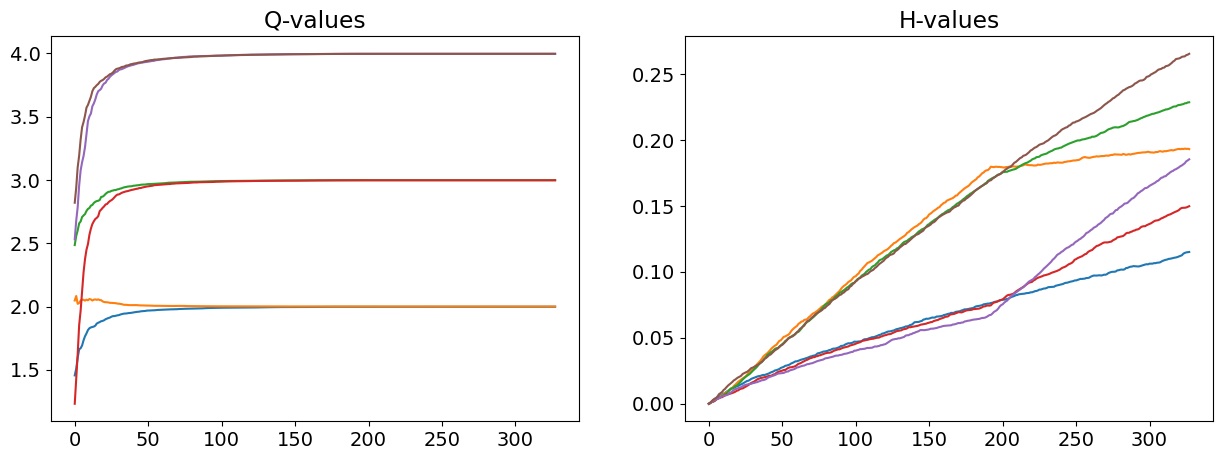

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(RL_values.mean(axis=0))
axs[0].set_title('Q-values')
axs[1].plot(CK_values.mean(axis=0))
axs[1].set_title('H-values')

In [84]:
C = np.zeros((RL_values.shape[0],))
for s in range(RL_values.shape[0]):
    C[s] = np.corrcoef(RL_values[s,...].flatten(), CK_values[s,...].flatten())[0,1]

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


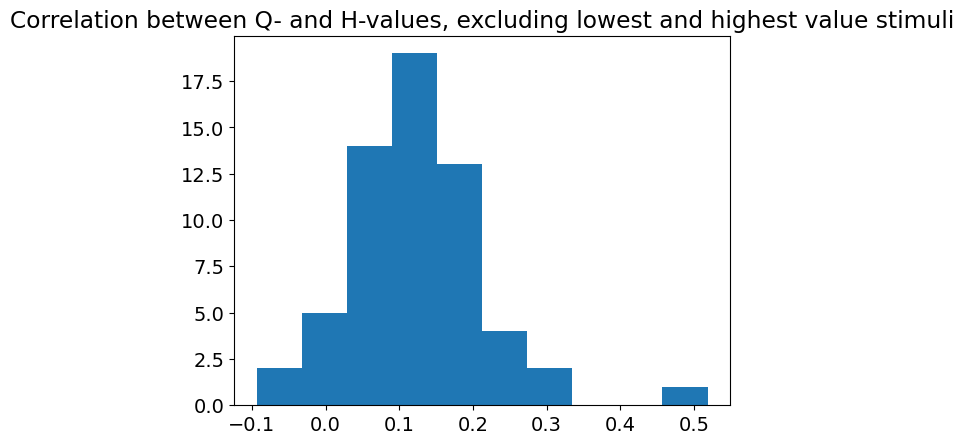

In [85]:
plt.hist(C, density=False)
plt.title('Correlation between Q- and H-values, excluding lowest and highest value stimuli')
plt.show()